# Multicolor fluoresence microscopy

See section 2.4 in the paper for full results.

The data we use in this notebook are BPAE cells taken with a 100x 1.4 NA Nikon Objective.

## Setup

Here we import some necessary packages/helper functions

In [1]:
!export CUDA_VISIBLE_DEVICES=0,1,2,3
%load_ext autoreload
%autoreload 2
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

import sys
sys.path.append("..") # since the package is one level above. Normally you should keep them on the same!
import rdmpy

# here are some basics we will need for the demo
import torch
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import resize
from skimage.measure import block_reduce
from PIL import Image

# Fill this in according to your computer, we highly recommend using a GPU.
# We needed ~20GB of GPU memory to run at full resolution (1024 x 1024).
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
    
print('Using ' +str(device) + ' for computation')

def center_crop(img, des_shape, center=None):
    if center is None:
        center = (img.shape[0] // 2, img.shape[1] // 2)
    left, right, up, down = (
        center[1] - des_shape[1] // 2,
        center[1] + int(np.round(des_shape[1] / 2)),
        center[0] - des_shape[0] // 2,
        center[0] + int(np.round(des_shape[0] / 2)),
    )
    img = img[up:down, left:right]
    return img

def crop(img, c):
    return img[c:-c,c:-c]

def outer_ring(image):
    image[0, :] = 0
    image[-1, :] = 0
    image[:, 0] = 0
    image[:, -1] = 0

    return image

def process(
    img,
    back,
    dim,
    center=None,
    hot_pix=False,
    tolerance=1,
    remove_outer=True,
    downsample=1,
):
    if center is None:
        center = (dim[0] // 2, dim[1] // 2)

    if back is not None:
        img = (img - back)
        img = img - img.min()
        img = img/img.max()

    # img[img < 0] = 0
    img = img[
        center[0] - dim[0] // 2 : center[0] + dim[0] // 2,
        center[1] - dim[1] // 2 : center[1] + dim[1] // 2,
    ]

    if remove_outer:
        img = outer_ring(img)

    img = block_reduce(img, block_size=(downsample, downsample), func=np.mean)

    return img/img.max()

GREEN = 518e-9
RED = RED = 650e-9

/home/amit/micromamba/envs/psf/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


Using cuda:0 for computation


## One-time Calibration

This multicolor case is slightly different. We need seperate PSFs for the green and red channel since diffraction is wavelength dependent. However, this can be captured using a single calibration image assuming no chromatic aberrations. Alternatively, we can calibrate them seperately. In this notebook we will do them separately. We will start with red channel.

In [ ]:
dim = 2040 # Pick this according to how big of an image you want to deblur. Reduce if memory errors.
center = [1022, 1024] #
patch_size=0 # set this larger if you need less memory or more speed.
base_dir='' # set this to the directory where you have the data if it's not in the same directory as this notebook.

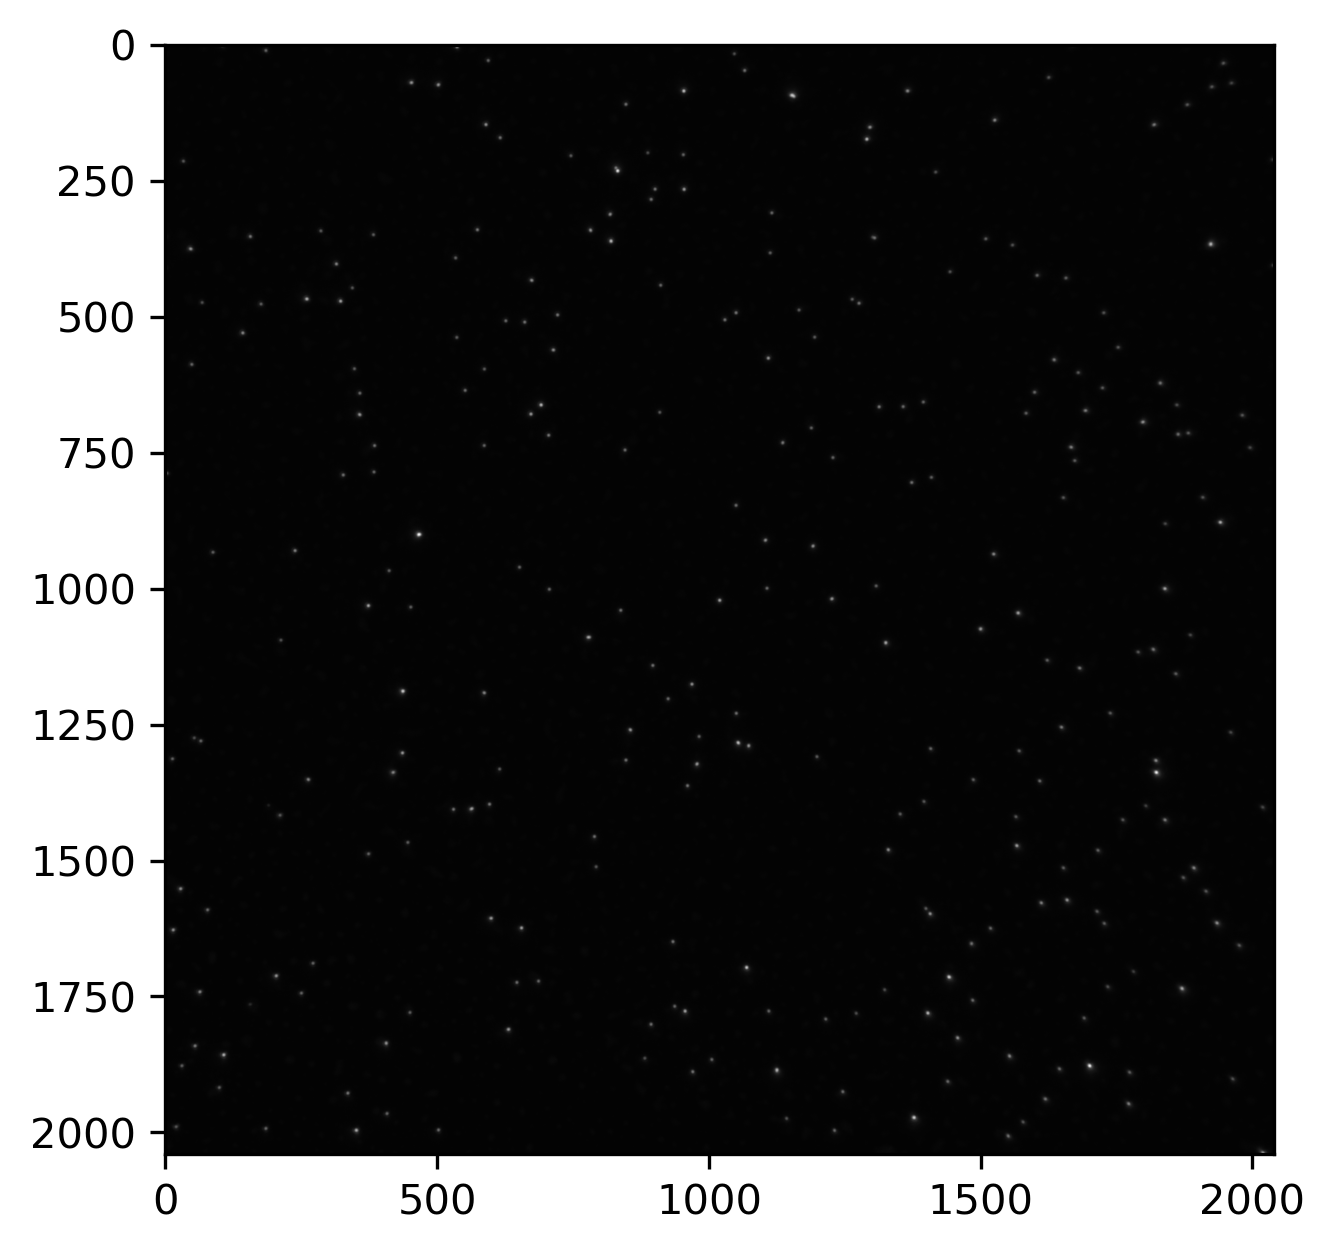

In [ ]:
calib_img_r = np.array(Image.open(base_dir+'rdm_data/multicolor/0.1_um_red_beads/0.1_um_red_beads_004.tif'))

plt.imshow(center_crop(calib_img_r**(1/2), [dim,dim]), cmap='gray')
plt.show()

Wow that's pretty dense, we can get around a super slow fit by increasing the min_distance parameter, which specifies the minimum distance between PSFs that we will fit.

fitting seidel coefficients...


100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


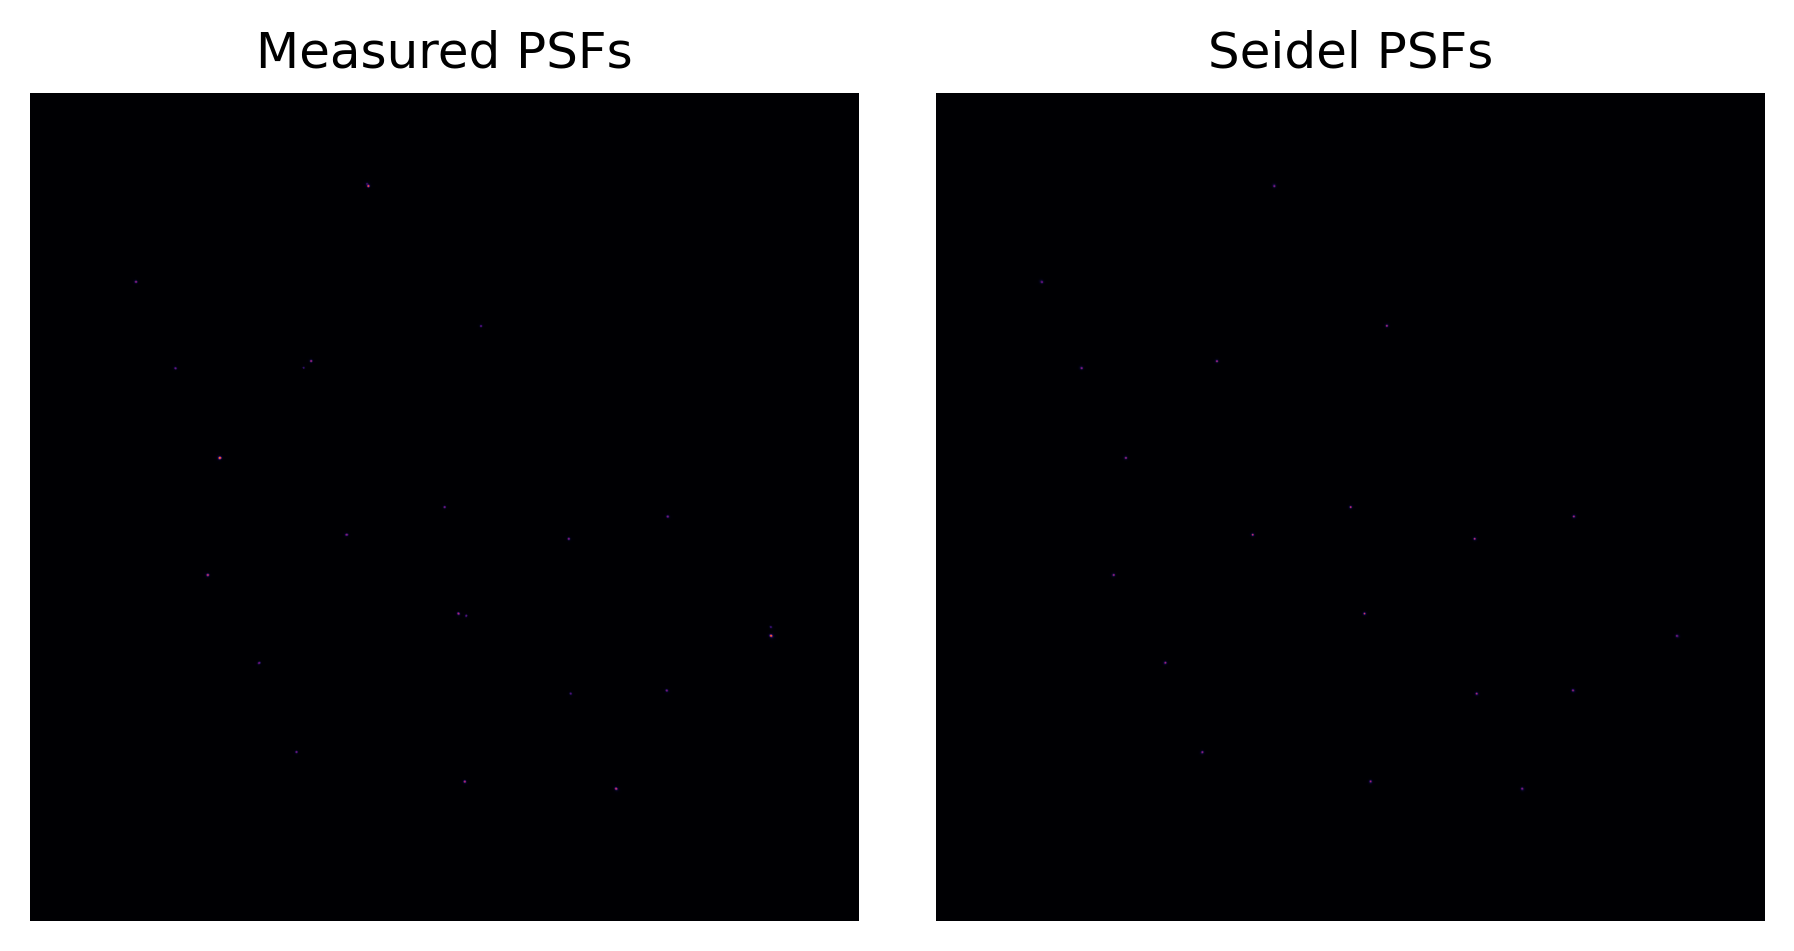

Fitted seidel coefficients: tensor([[0.4683],
        [0.2069],
        [0.1035],
        [0.1746],
        [0.0000],
        [0.0000]])


In [ ]:
fit_params={"sys_center": center, "iters": 100, "threshold": 0.2, "disk": 1, "lr": 7e-2, "min_distance": 200}
sys_params={"lamb" : RED}
seidel_coeffs_r = rdmpy.calibrate_rdm(calib_img_r, dim=dim, device=device, show_psfs=True, fit_params=fit_params, get_psfs=False, sys_params=sys_params)

Now we do the same for the green channel

fitting seidel coefficients...


100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


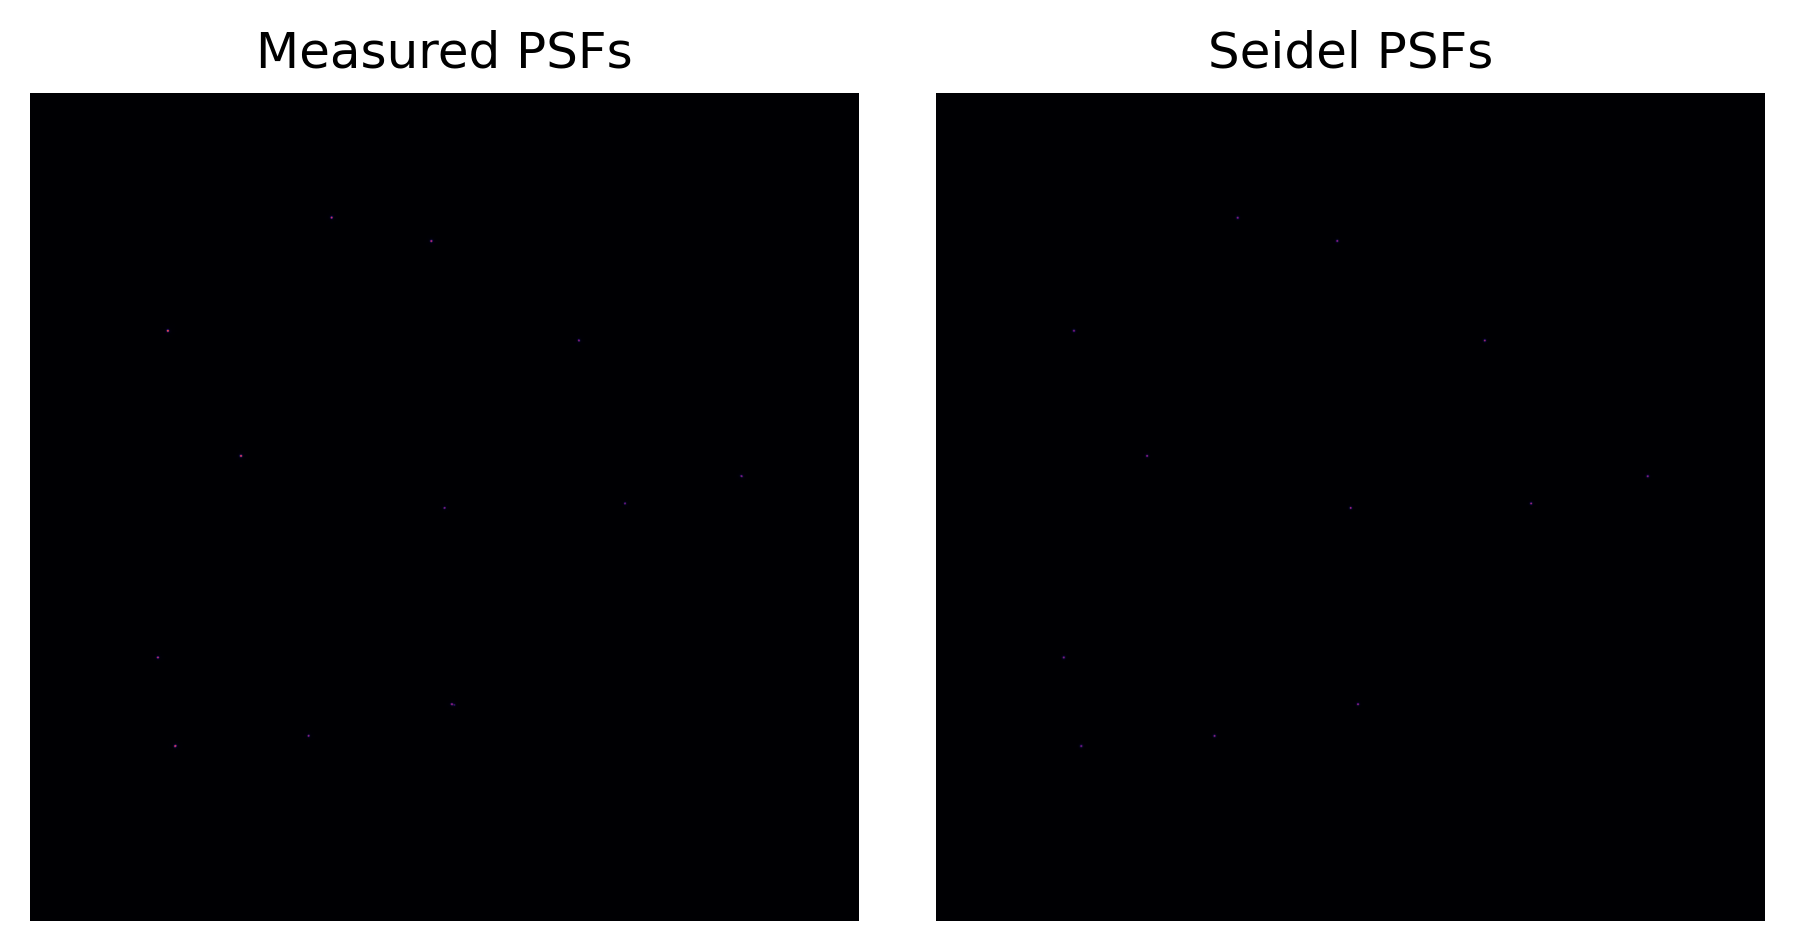

Fitted seidel coefficients: tensor([[0.5265],
        [0.0018],
        [0.0165],
        [0.1623],
        [0.0000],
        [0.0000]])


In [ ]:
calib_img_g = np.array(Image.open(base_dir+'rdm_data/multicolor/0.1_um_green_beads/0.1_um_green_beads_004.tif'))
sys_params = {"lamb" : GREEN}
fit_params={"sys_center": center, "iters": 100, "threshold": 0.2, "disk": 1, "lr": 7e-2, "min_distance": 200}
seidel_coeffs_g = rdmpy.calibrate_rdm(calib_img_g, dim=dim, device=device, show_psfs=True, fit_params=fit_params, get_psfs=False, sys_params=sys_params)

Now we can read in each channel and deblur. Since our GPU isn't large enough for the full 2040x2040 image, will downsample the images by a factor of 2 and use rdmpy's downsampling feature.

In [ ]:
bpae = io.imread(base_dir+'rdm_data/multicolor/100x_1.4NA_BPAE_phalloidin488_mitotrackerRed/100x_1.4NA_BPAE_phalloidin488_mitotrackerRed_000.tif')
bpae_r = bpae[1]
bpae_g = bpae[0]

bpae_r = process(bpae_r, back=None, dim=[dim,dim], center=center, downsample=2)
bpae_g = process(bpae_g, back=None, dim=[dim,dim], center=center, downsample=2)


In [ ]:
sys_params = {"lamb" : RED}
psf_data_r = rdmpy.get_rdm_psfs(seidel_coeffs_r, dim=dim, downsample=2, model='lri', sys_params=sys_params, device=device, patch_size=patch_size)

rendering PSFs...


100%|██████████| 1020/1020 [04:14<00:00,  4.01it/s]


100%|██████████| 200/200 [02:59<00:00,  1.12it/s]


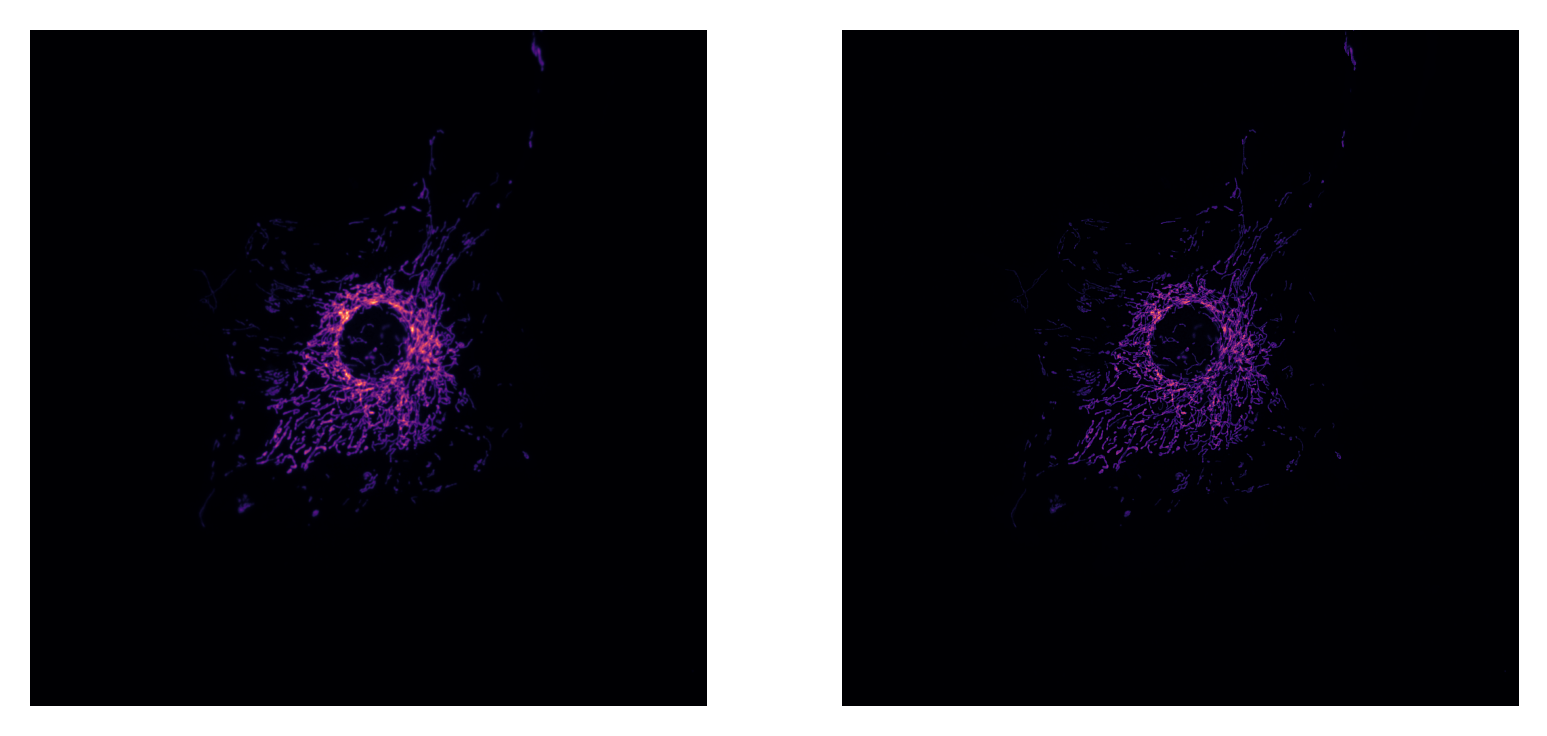

In [ ]:
c = 10
torch.cuda.empty_cache()
bpae_recon_r = rdmpy.ring_deconvolve(
    bpae_r,
    psf_data_r,
    process=True,
    patch_size=patch_size,
    opt_params={
        "lr": 5e-2,
        "iters": 200,
        "tv_reg": 1e-10,
        "l2_reg": 1e-9,
        "l1_reg": 0,
        "fraction": 4,
    },
    device=device,
)
bpae_recon_r = bpae_recon_r/bpae_recon_r.max()

# plot raw and ring deconvolved beads
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(crop(bpae_r,c), cmap='magma')
ax1.axis('off')
ax2.imshow(crop(bpae_recon_r,c), cmap='magma')
ax2.axis('off') 
plt.show()

Now again for the green channel. We are going to delete the red PSFs to make room. In practice, we would deblur all the red channels of a video or image stack first and then do all the green channels to avoid regenerating the PSFs multiple times

In [ ]:
del psf_data_r
sys_params = {"lamb" : GREEN}
psf_data_g = rdmpy.get_rdm_psfs(seidel_coeffs_g, dim=dim, model='lri', downsample=2, sys_params=sys_params, device=device, patch_size=patch_size)

rendering PSFs...


100%|██████████| 1020/1020 [04:01<00:00,  4.22it/s]


100%|██████████| 200/200 [02:58<00:00,  1.12it/s]


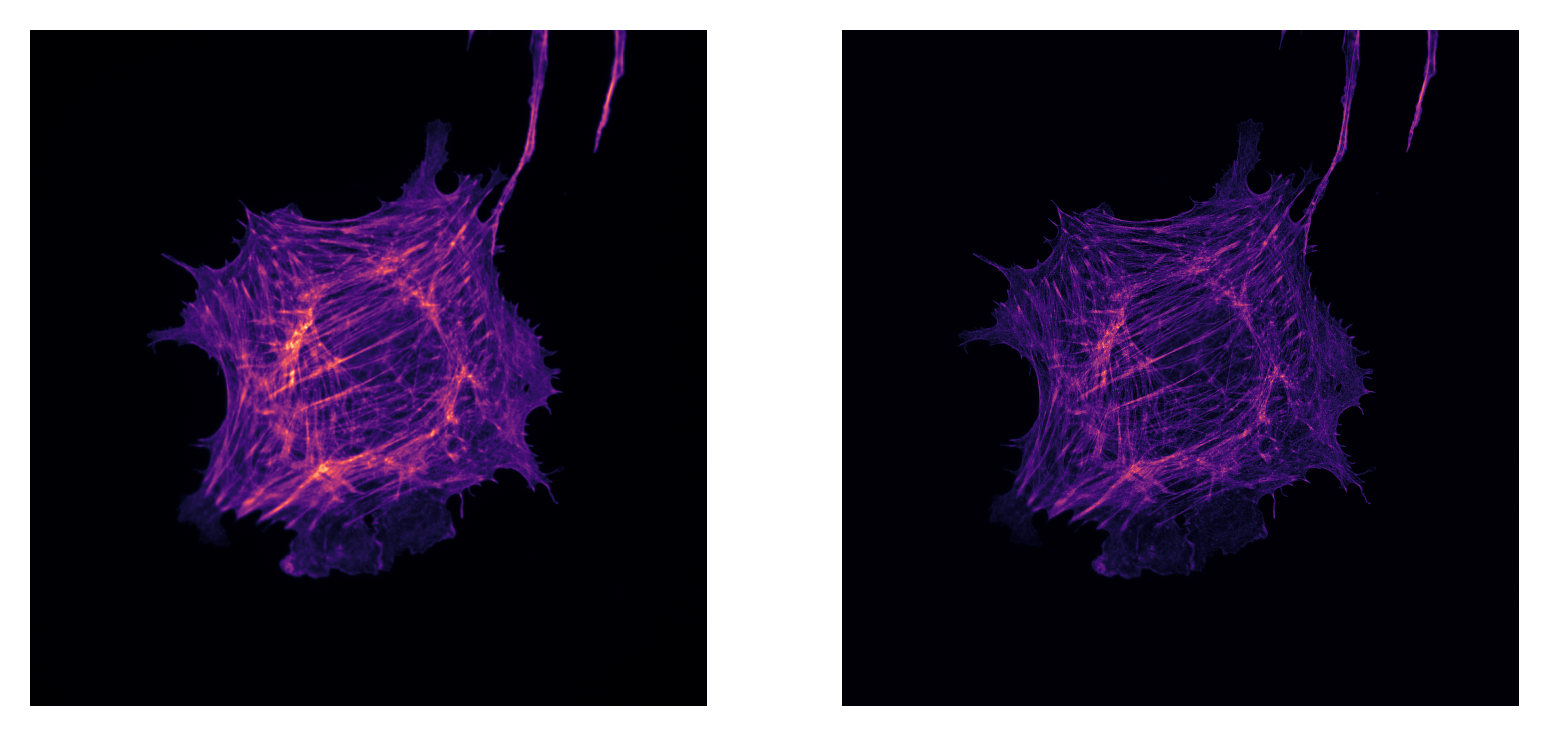

In [ ]:
torch.cuda.empty_cache()
bpae_recon_g = rdmpy.ring_deconvolve(
    bpae_g,
    psf_data_g,
    process=True,
    patch_size=patch_size,
    opt_params={
        "lr": 5e-2,
        "iters": 200,
        "tv_reg": 1e-10,
        "l2_reg": 1e-9,
        "l1_reg": 0,
    },
    device=device,
)
bpae_recon_g = bpae_recon_g/bpae_recon_g.max()

# plot raw and ring deconvolved beads
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(crop(bpae_g,c), cmap='magma')
ax1.axis('off')
ax2.imshow(crop(bpae_recon_g,c), cmap='magma')
ax2.axis('off') 
plt.show()

Now we can visualize the multicolor image! Note that this won't exactly match the paper, since in the paper we use ImageJ to recolor the red channels to magenta, making it more accessible to red-green colorblindness.

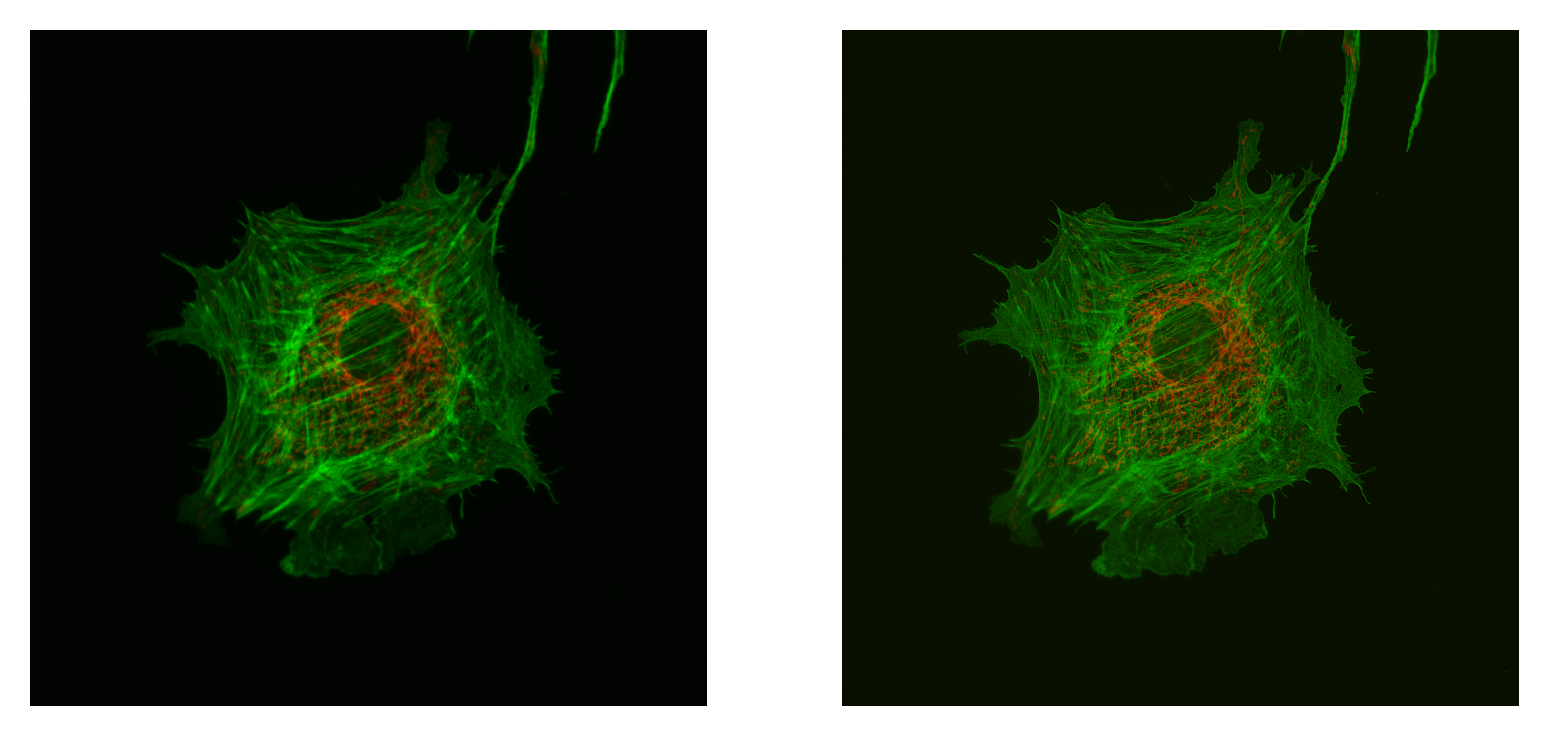

In [15]:
bpae_raw = np.stack(
        [bpae_r, bpae_g, np.zeros_like(bpae_r)], axis=2
)
bpae_recon = np.stack(
        [bpae_recon_r, bpae_recon_g, np.zeros_like(bpae_recon_r)], axis=2
)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(crop(bpae_raw,c))
ax1.axis('off')
ax2.imshow(crop(bpae_recon**0.6,c)) # mild contrast stretch bc of background reduction
ax2.axis('off') 
plt.show()

We could also use DeepRD by padding the image to 1024x1024, however this is suboptimal to retraining the model for the correct size. In the future, we will use embeddings to allow DeepRD to handle any image size!